### Adaptive RAG Example 2: Medical Diagnosis Assistant
This system adapts retrieval strategy based on medical query complexity and urgency


In [19]:
import os
from typing import Literal, List, Dict
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_community.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.tools.tavily_search import TavilySearchResults
from pydantic import BaseModel, Field
from langgraph.graph import StateGraph, END, START
from typing_extensions import TypedDict
from IPython.display import display, Image
import json

In [12]:
from dotenv import load_dotenv
load_dotenv()

os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")

In [13]:
class MedicalQueryRouter(BaseModel):
    """Route medical queries based on urgency and complexity."""
    
    urgency_level: Literal["emergency", "urgent", "routine", "informational"] = Field(
        description="Assess urgency: emergency for life-threatening, urgent for concerning symptoms, routine for general questions, informational for research"
    )
    
    specialty_area: Literal["general_medicine", "cardiology", "neurology", "psychiatry", "pediatrics", "emergency_medicine"] = Field(
        description="Identify medical specialty most relevant to the query"
    )
    
    information_type: Literal["symptoms", "diagnosis", "treatment", "drug_interactions", "recent_research"] = Field(
        description="Categorize the type of medical information needed"
    )

class MedicalDocumentGrader(BaseModel):
    """Grade medical documents for clinical relevance and evidence quality."""
    
    clinical_relevance: str = Field(description="Clinical relevance: 'high', 'medium', 'low'")
    evidence_level: str = Field(description="Evidence quality: 'systematic_review', 'rct', 'cohort_study', 'case_report', 'expert_opinion'")
    safety_concern: str = Field(description="Safety implications: 'critical', 'moderate', 'low', 'none'")



class SymptomChecker(BaseModel):
    """Analyze symptoms and suggest possible conditions."""
    
    symptom_severity: str = Field(description="Severity assessment: 'severe', 'moderate', 'mild'")
    red_flags: List[str] = Field(description="List of concerning symptoms that require immediate attention")
    differential_diagnoses: List[str] = Field(description="List of possible conditions based on symptoms")


In [4]:
class MedicalGraphState(TypedDict):
    question: str
    patient_info: Dict
    urgency_level: str
    specialty_area: str
    documents: List[str]
    generation: str
    safety_alerts: List[str]
    recommendations: List[str]

In [22]:
class MedicalAdaptiveRAG:
    def __init__(self):
        self.llm = ChatOpenAI(model="gpt-4", temperature=0)
        self.embeddings = OpenAIEmbeddings()
        self.web_search = TavilySearchResults(k=3)
        
        # Initialize medical knowledge bases
        self.medical_knowledge = self._build_medical_knowledge_base()
        self.drug_database = self._build_drug_database()
        
        # Set up specialized components
        self.query_router = self._setup_medical_router()
        self.document_grader = self._setup_medical_grader()
        self.symptom_checker = self._setup_symptom_checker()
        
        # Build the medical workflow graph
        self.workflow = self._build_medical_workflow()
    
    def _build_medical_knowledge_base(self):
        """Build comprehensive medical knowledge base."""
        # In practice, this would load from medical databases, textbooks, journals
        medical_sources = [
            "harrison_internal_medicine.txt",
            "nejm_recent_articles.txt",
            "mayo_clinic_guidelines.txt",
            "cdc_guidelines.txt"
        ]
        
        documents = []
        for source in medical_sources:
            if os.path.exists(source):
                loader = TextLoader(source)
                documents.extend(loader.load())
        
        if documents:
            text_splitter = RecursiveCharacterTextSplitter(
                chunk_size=800,
                chunk_overlap=100,
                separators=["\n\n", "\n", ".", "!", "?", ",", " ", ""]
            )
            
            doc_splits = text_splitter.split_documents(documents)
            vectorstore = FAISS.from_documents(doc_splits, self.embeddings)
            return vectorstore.as_retriever()
    
    def _build_drug_database(self):
        """Build drug interaction and information database."""
        # This would typically connect to FDA databases, drug interaction checkers
        drug_sources = [
            "fda_drug_database.txt",
            "drug_interactions.txt",
            "contraindications.txt"
        ]
        
        documents = []
        for source in drug_sources:
            if os.path.exists(source):
                loader = TextLoader(source)
                documents.extend(loader.load())
        
        if documents:
            text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
            doc_splits = text_splitter.split_documents(documents)
            vectorstore = FAISS.from_documents(doc_splits, self.embeddings)
            return vectorstore.as_retriever()
        
        # Create mock drug database
        sample_drug_docs = [
            "Metformin contraindications: severe kidney disease, acute heart failure, liver disease. Monitor renal function.",
            "Aspirin interactions: increases bleeding risk with warfarin. Avoid in active peptic ulcers.",
            "Statins: muscle pain is common side effect. Monitor for rhabdomyolysis with creatine kinase elevation."
        ]
        
        from langchain.schema import Document
        mock_docs = [Document(page_content=content) for content in sample_drug_docs]
        vectorstore = FAISS.from_documents(mock_docs, self.embeddings)
        return vectorstore.as_retriever()

    def _setup_medical_router(self):
        """Set up intelligent medical query routing."""
        router_llm = self.llm.with_structured_output(MedicalQueryRouter)
        
        system_prompt = """You are a medical triage assistant. Analyze the medical query and determine:
        1. Urgency level (emergency, urgent, routine, informational)
        2. Relevant medical specialty
        3. Type of information needed
        
        Emergency indicators: chest pain, difficulty breathing, severe bleeding, loss of consciousness
        Urgent indicators: persistent pain, fever, significant symptom changes
        Routine: general health questions, medication inquiries
        Informational: research questions, health education
        
        IMPORTANT: Always err on the side of caution for patient safety.
        """
        
        route_prompt = ChatPromptTemplate.from_messages([
            ("system", system_prompt),
            ("human", "Medical Query: {question}\nPatient Context: {patient_info}")
        ])
        
        return route_prompt | router_llm

    def _setup_medical_grader(self):
        """Set up medical document grading system."""
        grader_llm = self.llm.with_structured_output(MedicalDocumentGrader)
        
        system_prompt = """You are a medical evidence evaluator. Assess documents based on:
        1. Clinical relevance to the medical question
        2. Quality of evidence (systematic reviews > RCTs > cohort studies > case reports)
        3. Safety implications
        
        Prioritize recent, peer-reviewed sources and official medical guidelines.
        Flag any safety concerns or contraindications.
        """
        
        grade_prompt = ChatPromptTemplate.from_messages([
            ("system", system_prompt),
            ("human", "Document: {document}\nMedical Question: {question}\nPatient Info: {patient_info}")
        ])
        
        return grade_prompt | grader_llm

    def _setup_symptom_checker(self):
        """Set up symptom analysis system."""
        checker_llm = self.llm.with_structured_output(SymptomChecker)
        
        system_prompt = """You are a symptom analysis assistant. Analyze presented symptoms and:
        1. Assess severity level
        2. Identify red flag symptoms requiring immediate attention
        3. Suggest possible differential diagnoses
        
        Red flags include: chest pain, difficulty breathing, severe headache, high fever, 
        loss of consciousness, severe bleeding, signs of stroke, severe abdominal pain.
        
        Always recommend seeking immediate medical attention for serious symptoms.
        """
        
        symptom_prompt = ChatPromptTemplate.from_messages([
            ("system", system_prompt),
            ("human", "Symptoms: {symptoms}\nPatient Info: {patient_info}")
        ])
        
        return symptom_prompt | checker_llm

    def route_medical_query(self, state):
        """Route medical queries based on urgency and complexity."""
        print("---MEDICAL QUERY ROUTING---")
        
        question = state["question"]
        patient_info = state.get("patient_info", {})
        
        routing_decision = self.query_router.invoke({
            "question": question,
            "patient_info": json.dumps(patient_info)
        })
        
        print(f"Urgency Level: {routing_decision.urgency_level}")
        print(f"Specialty Area: {routing_decision.specialty_area}")
        print(f"Information Type: {routing_decision.information_type}")
        
        return {
            **state,
            "urgency_level": routing_decision.urgency_level,
            "specialty_area": routing_decision.specialty_area
        }

    def retrieve_medical_information(self, state):
        """Retrieve medical information based on urgency and type."""
        print("---RETRIEVING MEDICAL INFORMATION---")
        
        question = state["question"]
        urgency = state["urgency_level"]
        specialty = state["specialty_area"]
        
        if urgency == "emergency":
            # Focus on emergency protocols and immediate interventions
            emergency_query = f"emergency {specialty} {question} immediate treatment"
            
            docs = []
            if self.medical_knowledge:
                docs = self.medical_knowledge.invoke(emergency_query)
            
            # Also search for latest emergency guidelines
            try:
                web_results = self.web_search.invoke({"query": f"emergency medical guidelines {question}"})
                docs.extend([{"content": r["content"]} for r in web_results])
            except:
                pass
            
            return {**state, "documents": docs[:2]}
        
        elif urgency == "urgent":
            # Comprehensive search including recent research
            docs = []
            if self.medical_knowledge:
                docs = self.medical_knowledge.invoke(question)
            
            # Check drug interactions if medication-related
            if "medication" in question.lower() or "drug" in question.lower():
                if self.drug_database:
                    drug_docs = self.drug_database.invoke(question)
                    docs.extend(drug_docs[:2])
            
            return {**state, "documents": docs}
        
        elif urgency == "routine":
            # Standard medical knowledge base search
            docs = []
            if self.medical_knowledge:
                docs = self.medical_knowledge.invoke(question)
            
            return {**state, "documents": docs[:4]}
        
        else:  # informational
            # Broader search including recent research
            docs = []
            if self.medical_knowledge:
                docs = self.medical_knowledge.invoke(question)
            
            try:
                web_results = self.web_search.invoke({"query": f"recent medical research {question}"})
                docs.extend([{"content": r["content"]} for r in web_results])
            except:
                pass
            
            return {**state, "documents": docs[:3]}
    
    def grade_medical_documents(self, state):
        """Grade medical documents for evidence quality and safety."""
        print("---GRADING MEDICAL DOCUMENTS---")
        
        question = state["question"]
        documents = state["documents"]
        patient_info = state.get("patient_info", {})
        urgency = state["urgency_level"]
        
        graded_docs = []
        safety_alerts = []
        
        for doc in documents:
            doc_content = doc.page_content if hasattr(doc, 'page_content') else doc.get("content", "") if isinstance(doc, dict) else str(doc)
            
            try:
                grade = self.document_grader.invoke({
                    "document": doc_content,
                    "question": question,
                    "patient_info": json.dumps(patient_info)
                })
                
                # Prioritize based on evidence quality and clinical relevance
                if grade.clinical_relevance in ["high", "medium"]:
                    graded_docs.append(doc)
                
                # Collect safety alerts
                if grade.safety_concern in ["critical", "moderate"]:
                    safety_alerts.append(f"Safety concern in document: {grade.safety_concern}")
            except:
                # If grading fails, include document anyway for emergency cases
                if urgency == "emergency":
                    graded_docs.append(doc)
        
        print(f"Selected {len(graded_docs)} clinically relevant documents")
        print(f"Identified {len(safety_alerts)} safety concerns")
        
        return {**state, "documents": graded_docs, "safety_alerts": safety_alerts}

    def analyze_symptoms(self, state):
        """Analyze symptoms if query involves symptom description."""
        print("---ANALYZING SYMPTOMS---")
        
        question = state["question"]
        patient_info = state.get("patient_info", {})
        
        # Check if query involves symptoms
        symptom_keywords = ["pain", "fever", "headache", "nausea", "fatigue", "symptoms", "hurt", "ache"]
        
        if any(keyword in question.lower() for keyword in symptom_keywords):
            try:
                symptom_analysis = self.symptom_checker.invoke({
                    "symptoms": question,
                    "patient_info": json.dumps(patient_info)
                })
                
                # Update safety alerts if red flags identified
                safety_alerts = state.get("safety_alerts", [])
                if symptom_analysis.red_flags:
                    safety_alerts.extend([f"Red flag symptom: {flag}" for flag in symptom_analysis.red_flags])
                
                return {
                    **state,
                    "safety_alerts": safety_alerts,
                    "symptom_analysis": {
                        "severity": symptom_analysis.symptom_severity,
                        "red_flags": symptom_analysis.red_flags,
                        "differential_diagnoses": symptom_analysis.differential_diagnoses
                    }
                }
            except:
                print("Symptom analysis failed, continuing without it")
        
        return state
    
    def generate_medical_response(self, state):
        """Generate comprehensive medical response with safety considerations."""
        print("---GENERATING MEDICAL RESPONSE---")
        
        question = state["question"]
        documents = state["documents"]
        urgency = state["urgency_level"]
        safety_alerts = state.get("safety_alerts", [])
        symptom_analysis = state.get("symptom_analysis", {})
        
        # Convert documents to text
        doc_text = []
        for doc in documents:
            if hasattr(doc, 'page_content'):
                doc_text.append(doc.page_content)
            elif isinstance(doc, dict):
                doc_text.append(doc.get("content", ""))
            else:
                doc_text.append(str(doc))
        
        medical_prompt = ChatPromptTemplate.from_messages([
            ("system", """You are a medical information assistant. Provide comprehensive medical information based on the retrieved documents.
            
            Structure your response:
            1. Medical Information/Analysis
            2. Evidence Summary
            3. Safety Considerations
            4. Recommendations
            5. Important Disclaimers
            
            For emergency cases, prioritize immediate actions.
            Always include appropriate medical disclaimers.
            Emphasize when to seek immediate medical attention."""),
            ("human", """Medical Question: {question}
            Urgency Level: {urgency}
            Medical Documents: {documents}
            Safety Alerts: {safety_alerts}
            Symptom Analysis: {symptom_analysis}
            
            Provide a comprehensive medical response.""")
        ])
        
        medical_chain = medical_prompt | self.llm
        
        response = medical_chain.invoke({
            "question": question,
            "urgency": urgency,
            "documents": "\n".join(doc_text),
            "safety_alerts": safety_alerts,
            "symptom_analysis": symptom_analysis
        })
        
        # Generate specific recommendations based on urgency
        recommendations = []
        if urgency == "emergency":
            recommendations.append("Seek immediate emergency medical attention")
            recommendations.append("Call 911 or go to the nearest emergency room")
        elif urgency == "urgent":
            recommendations.append("Contact your healthcare provider within 24 hours")
            recommendations.append("Monitor symptoms closely")
        elif urgency == "routine":
            recommendations.append("Discuss with your healthcare provider at next appointment")
            recommendations.append("Follow standard medical advice")
        else:
            recommendations.append("Consider discussing with healthcare provider if relevant")
            recommendations.append("Continue researching from reliable medical sources")
        
        return {
            **state,
            "generation": response.content,
            "recommendations": recommendations
        }

    def _build_medical_workflow(self):
        """Build the medical consultation workflow graph."""
        workflow = StateGraph(MedicalGraphState)
        
        # Add nodes
        workflow.add_node("route_query", self.route_medical_query)
        workflow.add_node("retrieve_info", self.retrieve_medical_information)
        workflow.add_node("grade_docs", self.grade_medical_documents)
        workflow.add_node("analyze_symptoms", self.analyze_symptoms)
        workflow.add_node("generate_response", self.generate_medical_response)
        
        # Add edges
        workflow.add_edge(START, "route_query")
        workflow.add_edge("route_query", "retrieve_info")
        workflow.add_edge("retrieve_info", "grade_docs")
        workflow.add_edge("grade_docs", "analyze_symptoms")
        workflow.add_edge("analyze_symptoms", "generate_response")
        workflow.add_edge("generate_response", END)

        graph= workflow.compile()
        # graph.name = "Medical Adaptive RAG Workflow"
        # graph.description = "Adaptive RAG workflow for medical diagnosis and consultation, adapting retrieval and response based on query urgency and complexity."
        # graph.metadata = {
        #     "version": "1.0",
        #     "author": "LangGraph Team",
        #     "date_created": "2023-10-01",
        #     "last_updated": "2023-10-01",
        #     "tags": ["medical", "adaptive-rag", "diagnosis", "consultation"]
        #         }

        from IPython.display import Image, display
        display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
        return graph
    
    def consult(self, question: str, patient_info: Dict = None) -> Dict:
        """Main consultation interface."""
        if patient_info is None:
            patient_info = {}
        
        initial_state = {
            "question": question,
            "patient_info": patient_info,
            "documents": [],
            "generation": "",
            "safety_alerts": [],
            "recommendations": []
        }
        
        result = self.workflow.invoke(initial_state)
        
        return {
            "question": result["question"],
            "urgency_level": result.get("urgency_level", "unknown"),
            "response": result["generation"],
            "safety_alerts": result["safety_alerts"],
            "recommendations": result["recommendations"]
        }

Initializing Medical Adaptive RAG System...


c:\Users\chakr\anaconda3\envs\langgraph\Lib\site-packages\langchain_openai\chat_models\base.py:1857: UserWarning: Cannot use method='json_schema' with model gpt-4 since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


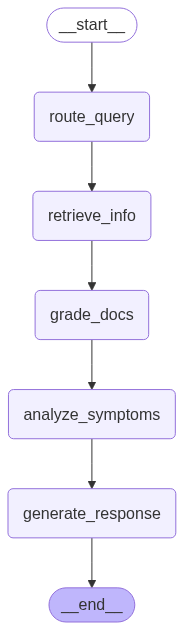


MEDICAL CONSULTATION EXAMPLE 1
---MEDICAL QUERY ROUTING---
Urgency Level: emergency
Specialty Area: cardiology
Information Type: symptoms
---RETRIEVING MEDICAL INFORMATION---
---GRADING MEDICAL DOCUMENTS---
Selected 2 clinically relevant documents
Identified 2 safety concerns
---ANALYZING SYMPTOMS---
---GENERATING MEDICAL RESPONSE---

QUESTION: I have severe chest pain and difficulty breathing
URGENCY LEVEL: emergency

RESPONSE:
1. Medical Information/Analysis:
Severe chest pain and difficulty breathing are critical symptoms that may indicate a serious condition such as a heart attack. These symptoms require immediate medical attention. 

2. Evidence Summary:
The documents retrieved emphasize the urgency of your symptoms. They suggest that even if the chest pain is not due to a heart attack, it could still be a sign of another serious condition. Therefore, it is critical to seek immediate medical help.

3. Safety Considerations:
The safety alerts in the documents highlight the critica

In [23]:
    # Example Usage
def run_medical_example():
    """Demonstrate medical assistant with different urgency levels."""
    
    print("Initializing Medical Adaptive RAG System...")
    medical_rag = MedicalAdaptiveRAG()
    
    # Test cases with different urgency levels
    test_cases = [
        {
            "question": "I have severe chest pain and difficulty breathing",
            "patient_info": {"age": 45, "gender": "male", "medical_history": ["hypertension"]},
            "expected_urgency": "emergency"
        },
        {
            "question": "I've had a persistent headache for 3 days with fever",
            "patient_info": {"age": 28, "gender": "female", "medical_history": []},
            "expected_urgency": "urgent"
        },
        {
            "question": "What are the side effects of metformin?",
            "patient_info": {"age": 55, "gender": "male", "medical_history": ["diabetes"]},
            "expected_urgency": "routine"
        },
        {
            "question": "What are the latest research findings on Alzheimer's prevention?",
            "patient_info": {"age": 65, "gender": "female", "medical_history": []},
            "expected_urgency": "informational"
        }
    ]
    
    for i, test_case in enumerate(test_cases, 1):
        print(f"\n{'='*60}")
        print(f"MEDICAL CONSULTATION EXAMPLE {i}")
        print(f"{'='*60}")
        
        try:
            result = medical_rag.consult( 
                question=test_case["question"],
                patient_info=test_case["patient_info"]
            )
            
            print(f"\nQUESTION: {result['question']}")
            print(f"URGENCY LEVEL: {result['urgency_level']}")
            print(f"\nRESPONSE:\n{result['response']}")
            
            if result['safety_alerts']:
                print(f"\nSAFETY ALERTS:")
                for alert in result['safety_alerts']:
                    print(f"⚠️  {alert}")
            
            if result['recommendations']:
                print(f"\nRECOMMENDATIONS:")
                for rec in result['recommendations']:
                    print(f"📋 {rec}")
            
        except Exception as e:
            print(f"Error processing consultation: {e}")
            print("This is expected if OpenAI API is not configured")

if __name__ == "__main__":
    run_medical_example()